In [ ]:
#Force google colab to switch to high ram mode. Run it only once. 
a = []
while(1):
    a.append('1')
#Also change runtime type to enable GPU from menu.

I am using test set for whole code because after running loading statement of train data my laptop is giving whole Ram has been used and call reconnect whole file


In [ ]:
##This block is only for access of files using google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import cv2;
import matplotlib.pyplot as plt
import numpy as np;
from random import shuffle;
import cv2;
from random import shuffle;
from tqdm import tqdm;
import tensorflow;
from tensorflow.keras import layers;
from tensorflow.keras import Model;
from tensorflow.keras.optimizers import SGD;
from tensorflow.keras.callbacks import TensorBoard;
IMAGE_SIZE = 75;

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
train_Data_File = drive.CreateFile({'id': '1JY6KgFazqhfBWyFOiBApyPJLL7v2sC4E'});
test_Data_File = drive.CreateFile({'id': '1Tziz-iSKEOEruEqNd6di0fEdR_O7o6zC'});

In [ ]:
#This block takes 6-10 minutes to load the training data and is consuming most of RAM
train_Data_File.GetContentFile('Cat_Dog_Train_Data.npy');
train_Data = np.load('Cat_Dog_Train_Data.npy', allow_pickle=True)

In [ ]:
train_Data.shape
#No of training images, First columns=images and second column=labels

(24500, 2)

In [ ]:
test_Data_File.GetContentFile('Cat_Dog_Test_Data.npy');  
test_Data = np.load('Cat_Dog_Test_Data.npy', allow_pickle= True)

In [ ]:
test_Data.shape
#No of test images, First columns=images and second column=labels

(500, 2)

In [ ]:
pip install keras-tuner

In [ ]:
import kerastuner as kt
from tensorflow import keras

In [ ]:
#forming the label set to give in keras model, if value is 0 then its a cat and 1 if its a dog
x = [];
for i in range(500):
  p= test_Data[i][1];
  if p[0]>p[1]:
    x.append(0);
  else:
    x.append(1);

In [ ]:
def model_builder(hp):   #building model
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(75,75,3)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  for i in range(hp.Int('num_layers', 2, 5)): 
      model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),min_value=32,max_value=512,step=32), activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid','softmax'], default='relu')))
  model.add(keras.layers.Dense(2))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=4,
                     directory='VIR',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project VIR/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from VIR/intro_to_kt/tuner0.json


In [ ]:
X_train = np.array([i[0] for i in tqdm(test_Data)]);
#Y_train = np.array([i[1] for i in x]);

100%|██████████| 500/500 [00:00<00:00, 403531.27it/s]


In [ ]:
import tensorflow as tf   #converting numpy array into tensor
trainDataX_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
trainDataY_tensor = tf.convert_to_tensor(x, dtype=tf.float32)

In [ ]:
tuner.search(trainDataX_tensor,trainDataY_tensor, epochs=50, validation_split=0.2)

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)
model.summary()#this comes out our best model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16875)             0         
_________________________________________________________________
dense (Dense)                (None, 448)               7560448   
_________________________________________________________________
dense_1 (Dense)              (None, 320)               143680    
_________________________________________________________________
dense_2 (Dense)              (None, 384)               123264    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 770       
Total params: 7,828,162
Trainable params: 7,828,162
Non-trainable params: 0
_________________________________________________________________


In [ ]:

img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))


x = layers.Conv2D(16, 3)(img_input)
x = layers.BatchNormalization()(x);   #using BAD
x = layers.ReLU()(x);
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2)(x)


x = layers.Conv2D(32, 3)(x)
x = layers.BatchNormalization()(x);
x = layers.ReLU()(x);
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling2D(2)(x)


x = layers.Conv2D(64, 3)(x)
x = layers.BatchNormalization()(x);
x = layers.ReLU()(x);
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2)(x)


x = layers.Conv2D(128, 3)(x)
x = layers.BatchNormalization()(x);
x = layers.ReLU()(x);
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2)(x)


x = layers.Flatten()(x)


x = layers.Dense(448, activation='relu')(x)
x = layers.Dense(320, activation='relu')(x)
x = layers.Dense(384, activation='relu')(x)
#x = layers.Dense(, activation='relu')(x)
#x = layers.Dense(32, activation='relu')(x)

output = layers.Dense(2, activation='softmax')(x)

# Create model:
model = Model(img_input, output)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 73, 73, 16)        448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 73, 73, 16)        64        
_________________________________________________________________
re_lu_4 (ReLU)               (None, 73, 73, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 73, 73, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 32)        4640

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics=['acc']);

In [ ]:
# Prepare the data for the training by separating X and Y vectors.
#X_train = np.array([i[0] for i in tqdm(train_Data)]);

#Y_train = np.array([i[1] for i in train_Data]);

X_test = np.array([i[0] for i in tqdm(test_Data)]);
Y_test = np.array([i[1] for i in test_Data]);

100%|██████████| 500/500 [00:00<00:00, 160615.15it/s]


In [ ]:
model.fit(X_test,Y_test, batch_size =64, epochs = 10,verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
8/8 [==============================] - 1s 57ms/step - loss: 0.9109 - acc: 0.4605 - val_loss: 0.6924 - val_acc: 0.5600
Epoch 2/10
8/8 [==============================] - 0s 30ms/step - loss: 0.6789 - acc: 0.6150 - val_loss: 0.6971 - val_acc: 0.4780
Epoch 3/10
8/8 [==============================] - 0s 27ms/step - loss: 0.5813 - acc: 0.7087 - val_loss: 0.7079 - val_acc: 0.4780
Epoch 4/10
8/8 [==============================] - 0s 25ms/step - loss: 0.5580 - acc: 0.6988 - val_loss: 0.7408 - val_acc: 0.4780
Epoch 5/10
8/8 [==============================] - 0s 25ms/step - loss: 0.5002 - acc: 0.7689 - val_loss: 0.7844 - val_acc: 0.4780
Epoch 6/10
8/8 [==============================] - 0s 26ms/step - loss: 0.4583 - acc: 0.7783 - val_loss: 0.8365 - val_acc: 0.4780
Epoch 7/10
8/8 [==============================] - 0s 25ms/step - loss: 0.4016 - acc: 0.8077 - val_loss: 0.8495 - val_acc: 0.4780
Epoch 8/10
8/8 [==============================] - 0s 25ms/step - loss: 0.4182 - acc: 0.8144 - val

In [ ]:
import matplotlib.pyplot as plt

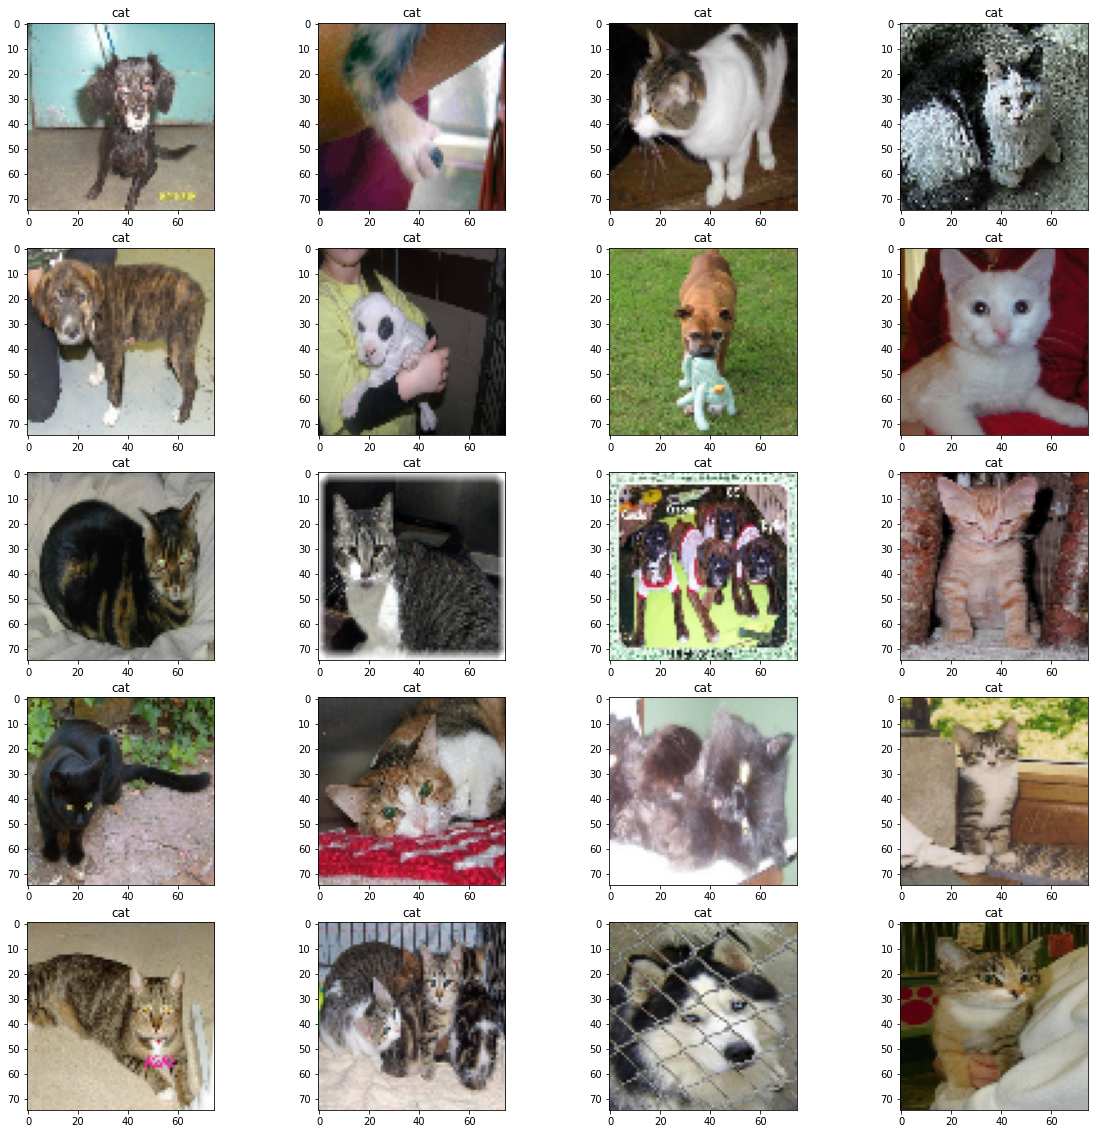

In [ ]:
#Show some random test images with their predictions as title.
count = 0;
Num_of_Images = 20;
plt.figure(figsize=(20,20))
for i in np.random.randint(500, size = Num_of_Images):
  count = count+1;
  plt.subplot(Num_of_Images/4,4, count);
  plt.imshow(X_test[i].reshape(IMAGE_SIZE, IMAGE_SIZE,3))
  P = model.predict(X_test[i].reshape(1,IMAGE_SIZE, IMAGE_SIZE,3))
  P = np.array(P);
  if(P[0,0]>P[0,1]):
      plt.title('cat')
  else:
      plt.title('dog')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #data augmentation.

In [ ]:
datagen = ImageDataGenerator(horizontal_flip = True, vertical_flip=True, rotation_range=30, width_shift_range= 0.2, height_shift_range= 0.2)
# fit parameters from data
datagen.fit(X_test)

In [ ]:
training_Generator = datagen.flow(X_test, Y_test, batch_size=32)

In [ ]:
model.fit_generator(generator=training_Generator, steps_per_epoch= 10, epochs= 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
10/10 [==============================] - 1s 49ms/step - loss: 0.8155 - acc: 0.5682
Epoch 2/10
10/10 [==============================] - 0s 45ms/step - loss: 0.6336 - acc: 0.6438
Epoch 3/10
10/10 [==============================] - 0s 45ms/step - loss: 0.6442 - acc: 0.6136
Epoch 4/10
10/10 [==============================] - 0s 44ms/step - loss: 0.6244 - acc: 0.6331
Epoch 5/10
10/10 [==============================] - 0s 45ms/step - loss: 0.6354 - acc: 0.6396
Epoch 6/10
10/10 [==============================] - 0s 45ms/step - loss: 0.6453 - acc: 0.6006
Epoch 7/10
10/10 [==============================] - 0s 45ms/step - loss: 0.5956 - acc: 0.6981
Epoch 8/10
10/10 [==============================] - 0s 44ms/step - loss: 0.6095 - acc: 0.6721
Epoch 9/10
10/10 [==============================] - 0s 46ms/step - loss: 0.5475 - acc: 0.7156
Epoch 10/10
10/10 [==============================] - 0s 43ms/step - loss: 0.6265 - acc: 0.6006
